In [31]:
import numpy as np
import matplotlib.pyplot as plt

seed = 42

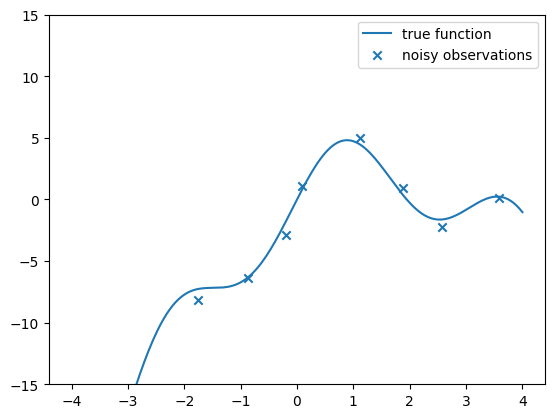

In [166]:
def func(x):
    return 3 * x + 3 * np.sin(2 * x) - x ** 2

grid = np.linspace(-4, 4, 200)
ys_true = np.array([func(x) for x in grid])

X = np.random.uniform(-4, 4, 10).reshape(-1, 1)
Y = np.array([func(x.squeeze()) for x in X]) + np.random.normal(0, 1, len(X))

plt.figure()

plt.plot(grid, ys_true, label='true function')
plt.scatter(X, Y, label='noisy observations', marker='x')

plt.ylim(-15, 15)
plt.legend()
plt.show()


## scikit-learn

The `GaussianProcessRegressor` fits a GP with covariance `kernel`.
- The mean function $\mu\equiv\overline{y}$ is implicitly assumed to be the constant mean observation value
- If the kernel has unfixed hyperparameters, model selection is performed by maximizing the evidence (resp. ELBO). Corresponding arguments are `optimizer` and `n_restarts_optimizer`
- Implicitly assumes Gaussian noise observation model $y|x, f\sim \mathcal{N}(f(x), \alpha)$ with noise level `alpha`
- Inference can be done analytically, but is approximated because of expensive matrix inversion

In [181]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

In [104]:
def visualize_gp_posterior(ax, gaussian_process, grid, n_samples, plot_confidence=True, title=None, xlims=None, ylims=None):
    samples = gaussian_process.sample_y(grid, n_samples)
    for j in range(n_samples):
        ax.plot(grid, samples[:, j], color='blue', alpha=.5)
    
    if plot_confidence:
        mean, std = gaussian_process.predict(grid, return_std=True)
        ax.plot(grid, mean, linewidth=2, linestyle='--', color='blue', label='mean')
        ax.fill_between(grid.flatten(), mean - 1.96 * std, mean + 1.96 * std,
                        color='blue', alpha=0.1, label='95% Confidence Interval')
    if title:
        ax.set_title(title)
    if xlims:
        ax.set_xlim(xlims)
    if ylims:
        ax.set_ylim(ylims)


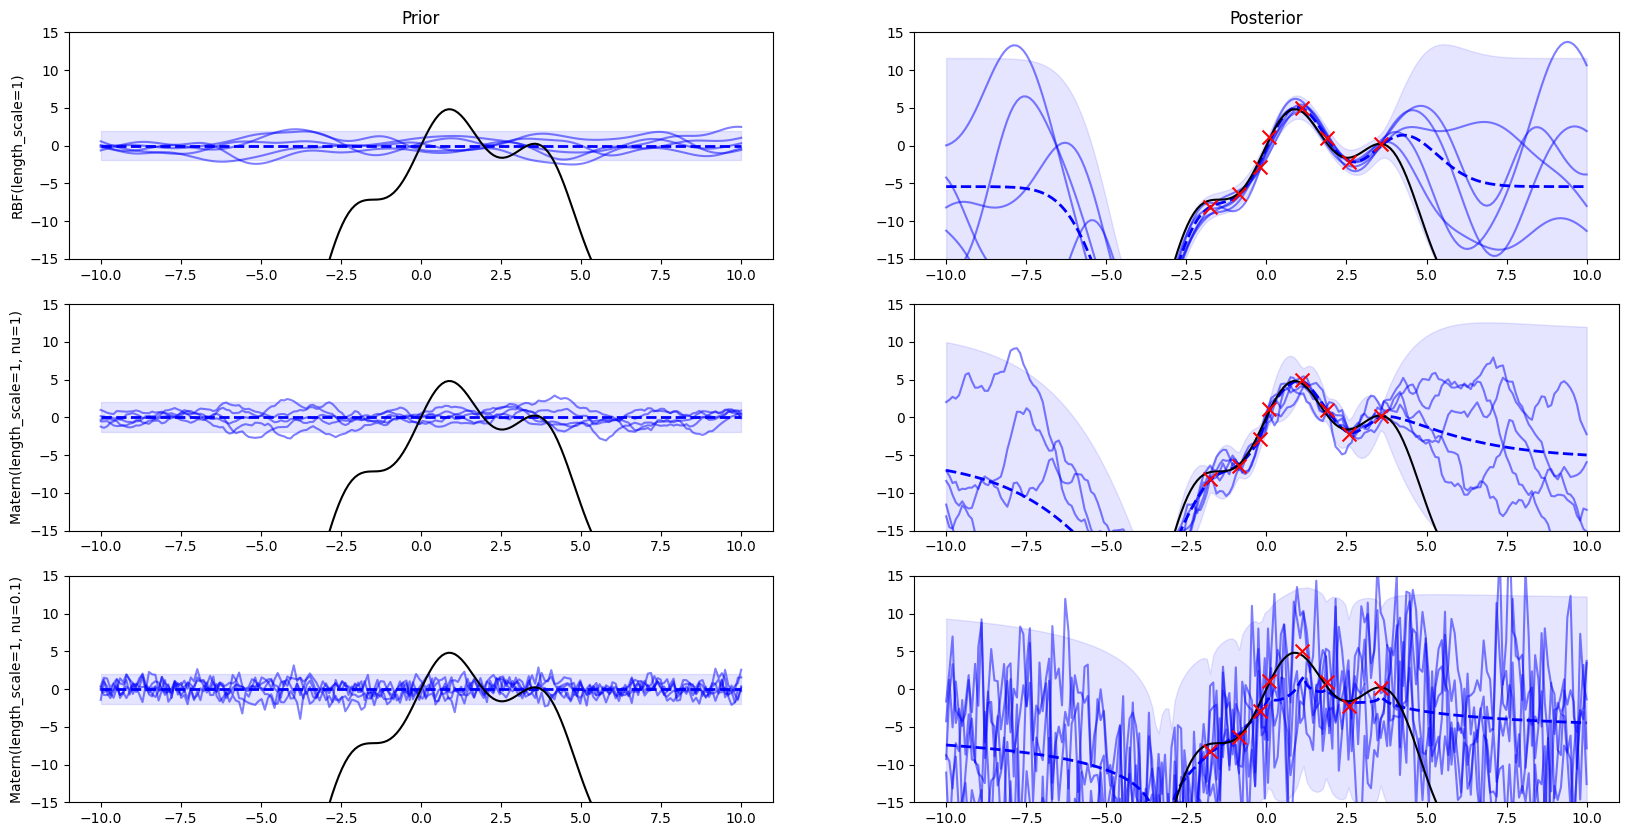

In [193]:
# gpr = GaussianProcessRegressor(kernel=RBF(length_scale=1), alpha=.01, normalize_y=True, random_state=seed)
gpr = GaussianProcessRegressor(kernel=Matern(length_scale=.1), alpha=.01, normalize_y=True, random_state=seed)

kernels = [RBF(length_scale=1), Matern(nu=1), Matern(nu=.1)]


# True function
grid = np.linspace(-10, 10, 200).reshape(-1, 1)
ys_true = np.array([func(x.squeeze()) for x in grid])


fig, axs = plt.subplots(nrows=len(kernels), ncols=2, figsize=(20, 10))
ylims = (-15, 15)

for i, kernel in enumerate(kernels):
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=.01, normalize_y=True, random_state=seed)
    axs[i, 0].set_ylabel(kernel)

    # Prior
    visualize_gp_posterior(axs[i, 0], gpr, grid, n_samples=5, title='Prior' if i == 0 else None, ylims=ylims)
    axs[i, 0].plot(grid, ys_true, label='true function', color='black')

    # Posterior
    visualize_gp_posterior(axs[i, 1], gpr.fit(X, Y), grid, n_samples=5, title='Posterior' if i == 0 else None, ylims=ylims)
    axs[i, 1].plot(grid, ys_true, label='true function', color='black')
    axs[i, 1].scatter(X, Y, color='red', marker='x', s=100, zorder=3)

plt.show()